*when doing the pivot table, it shows int32 overflow. I tried to split the whole table into a few, but still the whole process crashes, whether in Kaggle Kernel or Google Colab. So here before processing three tables, I will restrict their scope first.*

## Data Acquisition

#### get data

In [1]:
import pandas as pd

movie = 'movies.csv'
rating='ratings.csv'
tag='tags.csv'

movies = pd.read_csv(movie)
ratings=pd.read_csv(rating)
tags=pd.read_csv(tag)

In [2]:
print(tags.columns)
print(movies.columns)
print(ratings.columns)

Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')
Index(['movieId', 'title', 'genres'], dtype='object')
Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [ ]:
len(movies), len(ratings), len(tags)

(27278, 20000263, 465564)

#### how three tables interact

In [ ]:
movies['movieId'].value_counts()         #movie is uniquely shown here

1         1
91044     1
91035     1
91031     1
91028     1
         ..
26853     1
26851     1
26850     1
26849     1
131262    1
Name: movieId, Length: 27278, dtype: int64

In [ ]:
ratings['userId'].value_counts(),ratings['movieId'].value_counts()     #each user tags many movies; each movie is tagged by many users

(118205    9254
 8405      7515
 82418     5646
 121535    5520
 125794    5491
           ... 
 89305       20
 110463      20
 96990       20
 134747      20
 6526        20
 Name: userId, Length: 138493, dtype: int64,
 296       67310
 356       66172
 318       63366
 593       63299
 480       59715
           ...  
 125545        1
 78873         1
 112907        1
 112909        1
 110510        1
 Name: movieId, Length: 26744, dtype: int64)

In [ ]:
tags['userId'].value_counts(),tags['movieId'].value_counts()      #each user rates many movies; each movie is rated by many users

(88738     20356
 70201     13541
 130827    10642
 58612      9497
 123297     8369
           ...  
 76213         1
 76226         1
 76364         1
 76375         1
 138472        1
 Name: userId, Length: 7801, dtype: int64,
 296       1994
 2959      1779
 79132     1552
 2571      1430
 318       1339
           ... 
 116702       1
 116698       1
 116672       1
 116660       1
 1495         1
 Name: movieId, Length: 19545, dtype: int64)

## Data Restriction

In [3]:
ratings['userId']=ratings['userId'].apply(int)
newratings=ratings.loc[ratings['userId']<4000]

In [4]:
tags['userId']=tags['userId'].apply(int)
newtags=tags.loc[tags['userId']<4000]

In [5]:
len(newratings['movieId'].unique())

13096

In [6]:
len(newtags['movieId'].unique())

3932

In [7]:
newmovies=movies.loc[movies['movieId'].isin(list(newratings['movieId'].unique()))]

In [8]:
len(newmovies['movieId'].unique())

13096

In [9]:
print(len(newtags),len(newratings),len(newmovies))

16324 597451 13096


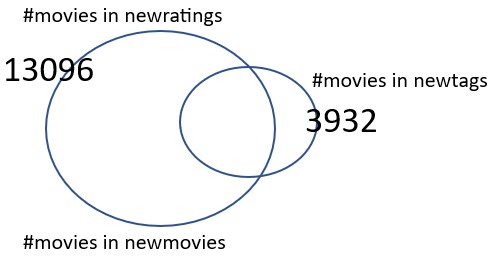

## A. content filter

#### metadata preparation

- "tags" groupby movie

In [10]:
newtags['tag']=newtags['tag'].apply(str)
newtags=newtags.drop(['userId','timestamp'],axis = 1) 

C:\Users\Fangyi\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
newtags_grouped = newtags.groupby('movieId')['tag'].agg('/'.join).reset_index()
newtags_grouped

,movieId,tag
0,1,Watched/computer animation/Disney animated fea...
1,2,time travel/adapted from:book/board game/child...
2,3,old people that is actually funny
3,6,realistic action/Al Pacino/Michael Mann/Robert...
4,7,Greg Kinnear/romance/remadeAs:Sabrina(1995)/re...
...,...,...
3927,127319,plot twists
3928,127323,fake imdb rating/plot holes
3929,128601,pain/tearjerker
3930,128622,crush/love story


- "tags" after grouby will combine with "movies" 

In [13]:
merge_movieandtag=pd.merge(newmovies, newtags_grouped, on='movieId',how='left')
merge_movieandtag

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Watched/computer animation/Disney animated fea...
1,2,Jumanji (1995),Adventure|Children|Fantasy,time travel/adapted from:book/board game/child...
2,3,Grumpier Old Men (1995),Comedy|Romance,old people that is actually funny
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,NaN
4,5,Father of the Bride Part II (1995),Comedy,NaN
...,...,...,...,...
13091,129707,The Lazarus Effect (2015),Horror|Thriller,NaN
13092,130052,Clown (2014),Drama|Horror,NaN
13093,130219,The Dark Knight (2011),Action|Crime|Drama|Thriller,NaN
13094,130490,Insurgent (2015),Action|Romance|Sci-Fi,NaN


In [14]:
merge_movieandtag['tag']=merge_movieandtag['tag'].fillna('')

- newly creatd col for merged data 

In [15]:
merge_movieandtag['genres']=merge_movieandtag['genres'].apply(str)

In [16]:
merge_movieandtag['metadata'] =merge_movieandtag[['genres', 'tag']].agg('++'.join, axis=1)

In [17]:
merge_movieandtag.head(5)

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Watched/computer animation/Disney animated fea...,Adventure|Animation|Children|Comedy|Fantasy++W...
1,2,Jumanji (1995),Adventure|Children|Fantasy,time travel/adapted from:book/board game/child...,Adventure|Children|Fantasy++time travel/adapte...
2,3,Grumpier Old Men (1995),Comedy|Romance,old people that is actually funny,Comedy|Romance++old people that is actually funny
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,,Comedy|Drama|Romance++
4,5,Father of the Bride Part II (1995),Comedy,,Comedy++


#### TF-IDF Vectorizer

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(merge_movieandtag['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=merge_movieandtag.index.tolist())
print(tfidf_df.shape)

(13096, 4888)


####  TruncatedSVD

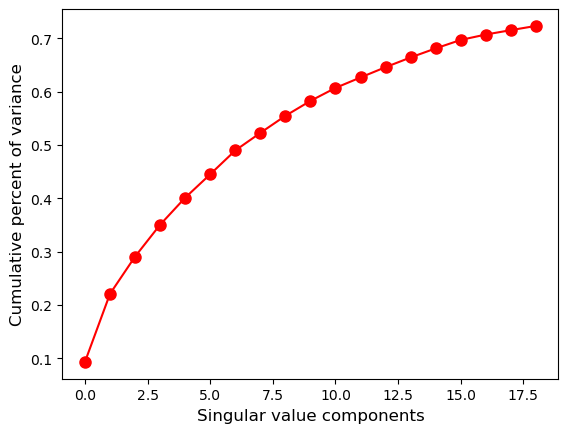

In [19]:
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=19)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [20]:
n = 20
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=merge_movieandtag.title.tolist())

In [21]:
latent_matrix_1_df.shape

(13096, 19)

### 

## B. collab filter

#### data preparation

In [22]:
from scipy.sparse import csr_matrix

In [23]:
user_movie = newratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)

#### SVD

In [24]:
type(merge_movieandtag)

pandas.core.frame.DataFrame

In [25]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(user_movie)
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=merge_movieandtag.title.tolist())

In [26]:
latent_matrix_2_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),102.023528,19.708067,20.113067,8.232885,9.623745,31.986201,-5.478682,-4.108649,34.902524,0.076986,...,2.691027,-0.272209,-5.183791,0.126593,3.463096,-0.052137,0.053260,4.034022,4.484666,1.794141
Jumanji (1995),47.161217,15.196263,20.994614,-10.435793,-7.035009,3.223028,-10.700278,8.392037,3.086887,0.230764,...,4.067185,2.848835,2.081262,-1.870380,0.999797,-0.029007,-0.786661,-1.769297,3.654931,-2.059279
Grumpier Old Men (1995),20.930193,13.498355,5.883769,-10.187227,-5.623388,-0.794089,-0.658927,-8.821523,16.141845,-6.298103,...,-2.329885,-0.123628,-0.882818,0.524774,-4.143247,-1.973761,-0.056784,2.597199,-2.610792,3.221534
Waiting to Exhale (1995),4.517838,5.606273,0.162506,-2.323248,-3.318866,-1.475562,2.012887,-0.375786,2.840841,0.020289,...,0.502412,-0.979458,-0.157258,0.074427,-1.493295,0.249033,-0.118099,1.524679,-0.812034,0.424601
Father of the Bride Part II (1995),18.631418,16.881051,10.798545,-10.086931,-8.285681,0.835244,-1.324984,-7.375952,15.291895,-4.915104,...,2.236692,1.867511,1.676197,-0.737940,1.642211,-2.009367,-2.426425,0.761807,-2.685679,3.230472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Lazarus Effect (2015),0.001714,0.000283,0.001496,0.000339,0.004762,0.004100,-0.001751,0.000292,0.001246,-0.000717,...,-0.001337,-0.003250,-0.003077,0.001988,0.002521,-0.000421,0.001757,-0.001193,-0.002904,-0.000909
Clown (2014),0.052921,-0.035301,-0.036490,0.037438,-0.057559,-0.081768,-0.049997,0.024276,0.013455,0.002974,...,0.026328,0.046706,-0.034342,-0.041789,0.027781,-0.034234,0.042741,-0.018513,0.025702,0.032924
The Dark Knight (2011),0.146252,-0.133183,0.250074,-0.055904,-0.075810,-0.000770,-0.179912,-0.326801,-0.055826,-0.001186,...,0.267507,-0.067479,0.067626,0.052419,-0.157802,-0.155677,-0.234110,-0.258854,0.032385,-0.041800
Insurgent (2015),0.188042,-0.139737,0.019075,-0.146404,-0.325309,0.066844,-0.028073,0.002099,0.217361,0.080414,...,-0.229657,-0.055488,0.273178,0.318717,-0.070865,-0.061786,0.135193,-0.071760,-0.112097,-0.008827


#### Plot variance expalined to see what latent dimensions to use

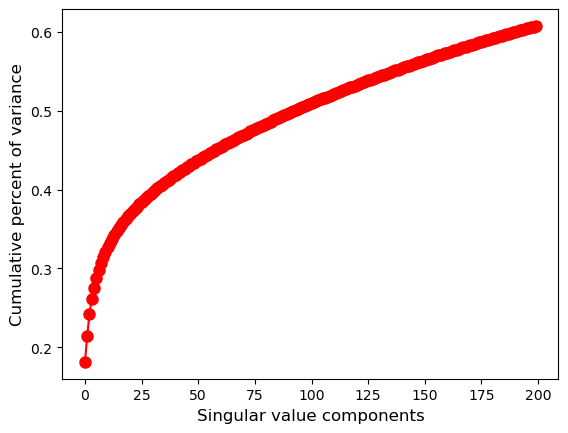

In [27]:
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

#### Cosine Similarity

In [28]:
import numpy as np

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
# take the latent vectors for a selected movie from both content 
# and collaborative matrixes
a_1 = np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc["Toy Story (1995)"]).reshape(1, -1)

# calculate the similartity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# an average measure of both content and collaborative 
hybrid = ((score_1 + score_2)/2.0)

# form a data frame of similar movies 
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
# dictDf = {'collaborative': score_2} 
similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )

#sort it on the basis of either: content, collaborative or hybrid, 
# here : content
similar.sort_values('content', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),0.993310,0.667980,0.830645
"Bug's Life, A (1998)",0.978288,0.573022,0.775655
"Incredibles, The (2004)",0.967860,0.488040,0.727950
"Monsters, Inc. (2001)",0.956841,0.541043,0.748942
Antz (1998),0.954934,0.454316,0.704625
"Tale of Despereaux, The (2008)",0.954464,0.102259,0.528362
Ponyo (Gake no ue no Ponyo) (2008),0.951564,0.157738,0.554651
Azur & Asmar (Azur et Asmar) (2006),0.951247,0.074201,0.512724
Cloudy with a Chance of Meatballs 2 (2013),0.946231,0.111734,0.528982
Wreck-It Ralph (2012),0.940529,0.199122,0.569826


#### Try Collaborative

In [30]:
similar.sort_values('collaborative', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),0.993310,0.667980,0.830645
Independence Day (a.k.a. ID4) (1996),0.049017,0.617066,0.333041
Star Wars: Episode IV - A New Hope (1977),0.162880,0.614186,0.388533
Mission: Impossible (1996),0.120939,0.609553,0.365246
Star Wars: Episode VI - Return of the Jedi (1983),0.115389,0.601382,0.358385
Willy Wonka & the Chocolate Factory (1971),0.224811,0.599154,0.411983
Back to the Future (1985),0.146167,0.590408,0.368288
Aladdin (1992),0.883969,0.589971,0.736970
"Lion King, The (1994)",0.740379,0.581976,0.661178
"Bug's Life, A (1998)",0.978288,0.573022,0.775655


#### Hybrid

In [31]:
similar.sort_values('hybrid', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),0.993310,0.667980,0.830645
"Bug's Life, A (1998)",0.978288,0.573022,0.775655
"Monsters, Inc. (2001)",0.956841,0.541043,0.748942
Aladdin (1992),0.883969,0.589971,0.736970
Finding Nemo (2003),0.935001,0.524405,0.729703
"Incredibles, The (2004)",0.967860,0.488040,0.727950
Shrek (2001),0.904711,0.536740,0.720726
Antz (1998),0.954934,0.454316,0.704625
Who Framed Roger Rabbit? (1988),0.908935,0.472690,0.690813
Shrek 2 (2004),0.920345,0.442187,0.681266


## Hybrid Recommendation System

In [32]:
def recommend_similar_movies(title):
    # take the latent vectors for a selected movie from both content 
    # and collaborative matrixes
    a_1 = np.array(latent_matrix_1_df.loc[title]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc[title]).reshape(1, -1)

    # calculate the similartity of this movie with the others in the list
    score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

    # an average measure of both content and collaborative 
    hybrid = ((score_1 + score_2)/2.0)

    # form a data frame of similar movies 
    dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
    similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )

    #sort it on the basis of either: content, collaborative or hybrid
    similar.sort_values('hybrid', ascending=False, inplace=True)

    print(similar[1:].head(11))

In [33]:
recommend_similar_movies("Toy Story (1995)")

                                  content  collaborative    hybrid
Toy Story 2 (1999)               0.993310       0.667980  0.830645
Bug's Life, A (1998)             0.978288       0.573022  0.775655
Monsters, Inc. (2001)            0.956841       0.541043  0.748942
Aladdin (1992)                   0.883969       0.589971  0.736970
Finding Nemo (2003)              0.935001       0.524405  0.729703
Incredibles, The (2004)          0.967860       0.488040  0.727950
Shrek (2001)                     0.904711       0.536740  0.720726
Antz (1998)                      0.954934       0.454316  0.704625
Who Framed Roger Rabbit? (1988)  0.908935       0.472690  0.690813
Shrek 2 (2004)                   0.920345       0.442187  0.681266
Space Jam (1996)                 0.844230       0.490624  0.667427


## matrix factorization

In [34]:
class MF():

    # Initializing the user-movie rating matrix, no. of latent features, alpha and beta.
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    # Initializing user-feature and movie-feature matrix 
    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # List of training samples
        self.samples = [
        (i, j, self.R[i, j])
        for i in range(self.num_users)
        for j in range(self.num_items)
        if self.R[i, j] > 0
        ]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    # Computing total mean squared error
    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Ratings for user i and moive j
    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Full user-movie rating matrix
    def full_matrix(self):
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)

In [35]:
R= np.array(newratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0))

In [36]:
mf = MF(R, K=20, alpha=0.001, beta=0.01, iterations=100)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()

Iteration: 20 ; error = 670.6139
Iteration: 40 ; error = 658.6856
Iteration: 60 ; error = 639.8731
Iteration: 80 ; error = 612.9872
Iteration: 100 ; error = 586.2848

P x Q:
[[3.89585116 3.50587774 3.38063105 ... 3.60152406 3.32942715 3.63702529]
 [4.56034147 4.06825714 3.67680166 ... 4.02934032 3.73607595 4.00593663]
 [4.41096763 3.63443696 3.64297494 ... 4.01879714 3.7750043  4.0330084 ]
 ...
 [3.56355942 2.72518559 2.51236584 ... 2.99296843 2.74143553 2.96504291]
 [3.96775882 3.27859994 3.28045892 ... 3.5996651  3.37641091 3.61134982]
 [3.84667917 3.10060337 3.04478959 ... 3.518118   3.37399045 3.61009454]]

